In [5]:
from PIL import Image

def rotate_and_scale(filename, min_angle=0,max_angle=180, scale=1, scale_id=None):
  src =  Image.open(f'../source/images/{filename}.png')
  for i in range(min_angle,max_angle):
    angle = i
    name = f'../source/images/generated/{filename}_{i}.png'
    dst = src.rotate(angle, resample=Image.NEAREST, expand=True, fillcolor=0)
    if scale_id is not None:
      width,height = dst.size
      dst = dst.resize((int(scale * width), int(scale*height)),resample=Image.NEAREST)
      name = f'../source/images/generated/{filename}_{i}_{scale_id}.png'
    dst = dst.crop(dst.getbbox())
    
    dst.save(name,bits=1,optimize=False)

Unique scales: 29


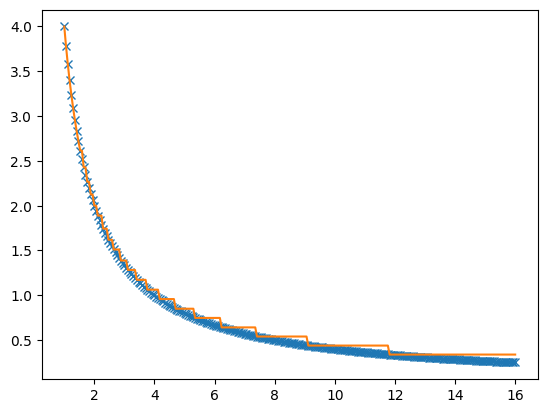

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(1,16,num=256)
y = 4/x

plt.plot(x,y,'x')

prev_scale = 5000
scales = []
count = 0
for scale in y:
  # keep values significantly different from previous
  if prev_scale-scale>0.1:
    prev_scale = scale
    count += 1
  scales.append(prev_scale)

print(f"Unique scales: {count}")
plt.plot(x,scales,'-')


In [7]:
import os
import numpy as np

os.makedirs("../source/images/generated",exist_ok=True)

# compute optimal number of sprites
x = np.linspace(1,16,num=256)
prev_scale = 5000
scales = []
scale_ids = []
unique_scales = []
for scale in 2/x:
  # keep values significantly different from previous
  if prev_scale-scale>0.1:
    prev_scale = scale
    unique_scales.append(scale)
  scale_ids.append(len(unique_scales)-1)
  scales.append(prev_scale)

print(f"Unique scales: {len(unique_scales)}")
# generate header file
with open("../lib3d/scales.h","w") as f:
  f.write(f'''
#ifndef _scales_h
#define _scales_h
#include <stdint.h>
/*
* generated - DO NOT EDIT
*/

// number of scaled images          
#define _scaled_image_count {len(unique_scales)}
// 1/z to scale id
static const uint8_t _scaled_by_z[{len(scale_ids)}]={{{",".join(map(str,scale_ids))}}};
#endif
''')

# full rotation images
for filename in ["arrow"]:
  rotate_and_scale(filename,min_angle=0,max_angle=360)

for filename in ["pine_snow_0"]:
  for i,scale in enumerate(unique_scales):
    rotate_and_scale(filename,min_angle=-30,max_angle=31,scale=scale, scale_id=i)

Unique scales: 16


In [76]:
from PIL import Image,ImageDraw
import math

# skybox
src =  Image.open('./sky_background_raw.png')
src = src.convert('RGBA')
src_width, src_height = src.size
for i in range(-30,30):
    angle = i
    # find extent
    dst = src.rotate(angle, resample=Image.BICUBIC, expand=True, fillcolor=(255,255,255,0))
    width, height = dst.size
    # find min/max height
    nx, ny = math.cos(angle * math.pi / 180), math.sin(angle * math.pi / 180)
    nx, ny = ny, -nx    
    extents = []
    for delta in [src_height/2,-src_height/2]:
      miny, maxy = math.inf, -math.inf
      extent = []
      for x in [-200,200]:        
          Nx, Ny = delta * nx, delta * ny
          t = (Nx - x) / ny
          y = Ny + t * nx
          extent.append(height/2+y)    
      extents.append(extent)
    top, bottom = min(extents[0]), max(extents[1])
    dst = dst.crop((width/2-200,top,width/2+200,bottom))
    width, height = dst.size
    img = Image.new('RGBA',size=(width,height),color=(0,0,0))
    draw = ImageDraw.Draw(img)
    draw.rectangle((0,0,width,height/2),fill=(255,255,255),width=0)
    img.alpha_composite(dst,(0,0))
    img = img.convert(mode="1")
    img.save(f'../source/images/generated/sky_background_{i}.png',bits=1,optimize=False)